In [78]:
import kwant
import kwant.continuum
import matplotlib.pyplot as plt
import numpy as np
import tinyarray

In [298]:
a=1  # lattice constant
sigma_0 = tinyarray.array([[1, 0], [0, 1]])
sigma_x = tinyarray.array([[0, 1], [1, 0]])
sigma_y = tinyarray.array([[0, -1j], [1j, 0]])  
sigma_z = tinyarray.array([[1, 0], [0, -1]])

qah_ham = "( M + V_sl(x,y) + B*(k_x**2+k_y**2)) * sigma_z + A * (k_x*sigma_x + k_y*sigma_y)"
qah_temp = kwant.continuum.discretize(qah_ham, grid=a)

lead_ham = "( M + B*(k_x**2+k_y**2)) * sigma_z + A * (k_x*sigma_x + k_y*sigma_y)"
lead_temp = kwant.continuum.discretize(lead_ham, grid=a)

Lx=5000
Ly=1

def rectangular(site):
    (x, y) = site.pos
    return (0 <= x < Lx and 0 <= y < Ly)

def lead_shape(site):
    (x, y) = site.pos
    return (0 <= y < Ly)

syst = kwant.Builder()
syst.fill(qah_temp, rectangular, (0, 0))

left_lead = kwant.Builder(kwant.TranslationalSymmetry([-a, 0]))
left_lead.fill(lead_temp, lead_shape, (0, 0))

#right_lead = kwant.Builder(kwant.TranslationalSymmetry([-a, 0]))
#right_lead.fill(qah_temp, lead_shape, (0, 0))

syst.attach_lead(left_lead)
syst.attach_lead(left_lead.reversed())

#syst.attach_lead(right_lead)

syst = syst.finalized()

In [299]:
d1=1
d2=0
V1=-0.5*0
V2=0.5*0

In [300]:
def potential(d1,d2,V1,V2):
    xperiod=d1+d2
    def heaviside(d1,xmod,y):
        if xmod<d1:
            return V1
        else:
            return V2
    def super_lattice(x,y):
        if 0<= y <Ly:
            return heaviside(d1, (x)%xperiod,y)
    return super_lattice

params=dict(A = 2, B = 0.1, M = 0, V_sl=potential(d1,d2,V1,V2))

In [76]:
%%time
trans10 = []
NE=501
energy=np.linspace(0,1.0,NE)

T_uu = []
T_dd = []

for i in range(len(energy)):
    smatrix = kwant.smatrix(syst, energy[i], params=params)
    print(f'\r{i}.step', end='', flush=True)
    T_uu.append(smatrix.transmission(1,0))
    #T_dd.append(smatrix.transmission((1,1),(0,1)))

500.stepWall time: 36.4 s


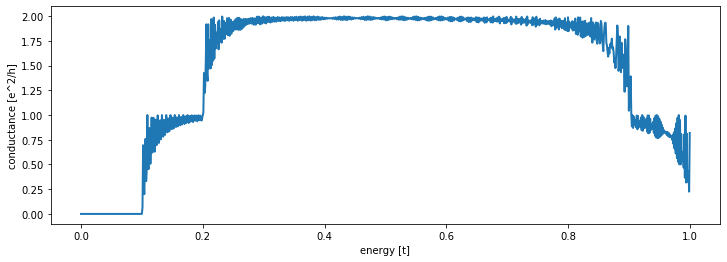

In [28]:
#Barrier-Well

plt.figure(figsize=(12,4))
plt.plot(energy,T_uu,'-',lw=2)
#plt.plot(energy,T_dd,'-',lw=2)
plt.xlabel("energy [t]")
plt.ylabel("conductance [e^2/h]")
#plt.xlim(0.,1)
#plt.ylim(-0.1,1.1)
plt.show()

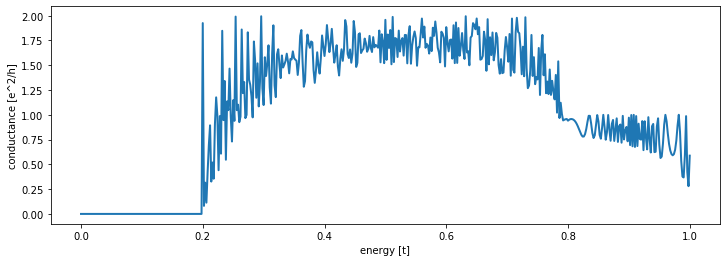

In [77]:
plt.figure(figsize=(12,4))
plt.plot(energy,T_uu,'-',lw=2)
#plt.plot(energy,T_dd,'-',lw=2)
plt.xlabel("energy [t]")
plt.ylabel("conductance [e^2/h]")
#plt.xlim(-0.01,0.5)
#plt.ylim(-0.1,1.1)
plt.show()

In [171]:
#np.savetxt('data/qah_cond_data_W={0}_L={1}_V1={2:.3f}_V2={3:.3f}_d1={4}_d2={5}_NE={6}_A={7}_B={8}_M={9}.txt'.format(
#            Ly, Lx, V1, V2, d1, d2, NE, params['A'],params['B'],params['M']),[energy,T_uu],fmt='%.18e')

In [347]:
%%time
def lead_system(qah_temp):
    xperiod=d1+d2
    def lead_shape(site): 
        (x, y) = site.pos
        return (0 <= y < Ly)

    lead = kwant.Builder(kwant.TranslationalSymmetry([-xperiod, 0]))
    lead.fill(lead_temp, lead_shape, (0, 0))
    syst = lead.finalized()
    
    return syst

lead_syst=lead_system(lead_temp)

#band structure
params_lead=dict(A = 2, B = 0.1, M = 0)
bands = kwant.physics.Bands(lead_syst, params=params_lead)
momenta = np.linspace(-np.pi, np.pi, 501)
energies = [bands(k) for k in momenta]

Wall time: 33.4 ms


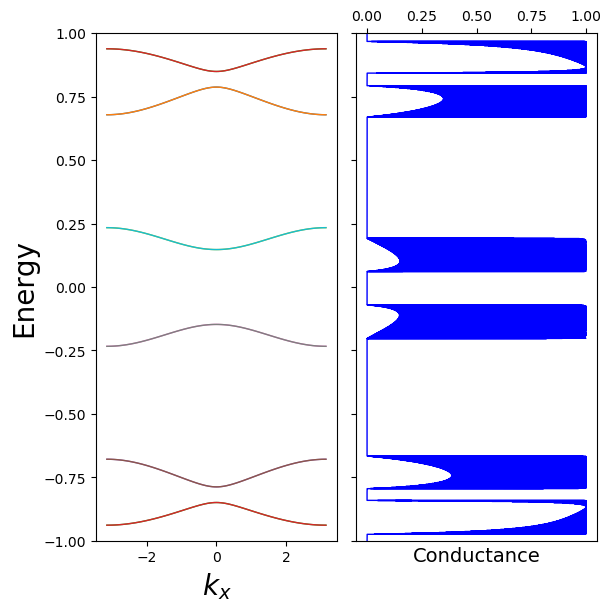

In [215]:
fig, ax = plt.subplots(1, 2, dpi=100, sharey=True, figsize=(6,6), constrained_layout=True)
#title='W={0}_L={1}_V1={2:.3f}_V2={3:.3f}_d1={4}_d2={5}_NE={6}.txt'.format(Ly, Lx, V1, V2, d1, d2, NE)
#ax[0].set_title('QAH \n W=1a, L=200a, $\lambda=8a, V=0.5t$',fontsize=10)

ax[0].plot(momenta, np.array(energies)[:,:],'-',lw=1)
ax[0].set_xlabel('$k_x$', fontsize=20)
ax[0].set_ylabel('Energy', fontsize=20)
ax[0].set_ylim(-1.,1.0)

a = 0.5*4 # half-width of the barriers
l = 1*4 # width of the wells

A = 1.0
M = 0.100001
V0 = 0.400001

NU=200
NE=200000

energy,cond=np.loadtxt('data/qah_1D_TB_KP_cond_dw={0}_db={1}_V0={2:.3f}_NU={3}_NE={4}_A={5}_M={6}.txt'.format(
                        2*a, l, V0, NU, NE, A, M))

ax[1].plot(cond,energy,'-b',lw=1)
ax[1].set_xlabel('Conductance', fontsize=14)
ax[1].xaxis.set_ticks_position('top')

(501, 2)


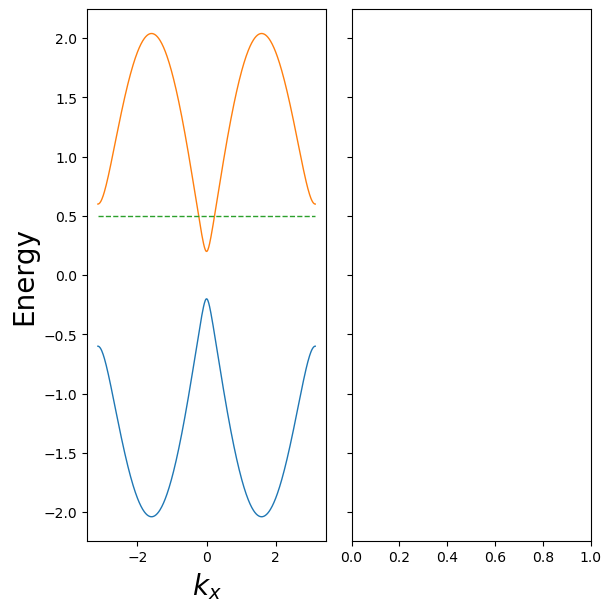

In [348]:
fig, ax = plt.subplots(1, 2, dpi=100, sharey=True, figsize=(6,6), constrained_layout=True)
#title='W={0}_L={1}_V1={2:.3f}_V2={3:.3f}_d1={4}_d2={5}_NE={6}.txt'.format(Ly, Lx, V1, V2, d1, d2, NE)
#ax[0].set_title('QAH \n W=1a, L=200a, $\lambda=8a, V=0.5t$',fontsize=10)

ax[0].plot(momenta, np.array(energies)[:,:],'-',lw=1)
ax[0].plot(momenta, 0.5*np.ones(len(momenta)),'--',lw=1)
ax[0].set_xlabel('$k_x$', fontsize=20)
ax[0].set_ylabel('Energy', fontsize=20)
#ax[0].set_ylim(-.5,.5)
print(np.shape(energies))

In [332]:
%%time
def lead_system(template):
    xperiod=d1+d2
    def lead_shape(site): 
        (x, y) = site.pos
        return (0 <= y < Ly)

    lead = kwant.Builder(kwant.TranslationalSymmetry([-xperiod, 0]))
    lead.fill(template, lead_shape, (0, 0))
    syst = lead.finalized()
    
    return syst

lead_syst=lead_system(lead_temp)

#band structure
bands = kwant.physics.Bands(lead_syst, params=params)
momenta = np.linspace(-np.pi, np.pi, 501)
energies = [bands(k) for k in momenta]

Wall time: 50.1 ms


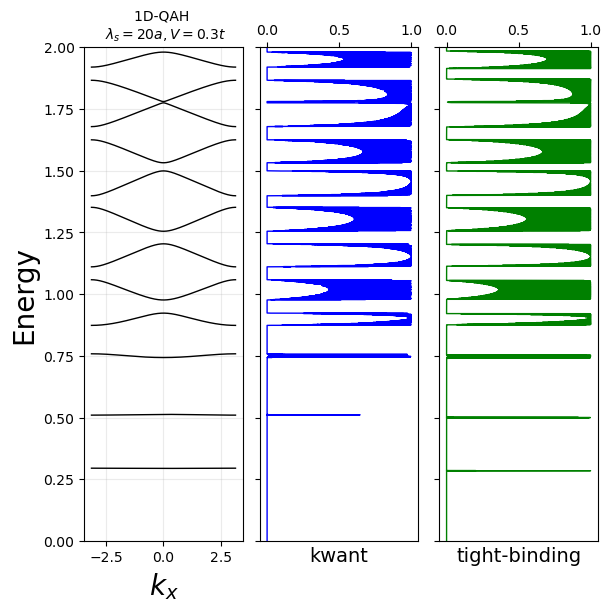

In [176]:
fig, ax = plt.subplots(1, 3, dpi=100, sharey=True, figsize=(6,6), constrained_layout=True)
#NE=101
#Lx=200
A,B,M,V=params.values()
EE=np.array(energies)

#ax[0].plot(momenta, np.zeros(len(momenta)),'--k',lw=1)
#ax[0].plot(momenta, 0.5*np.ones(len(momenta)),'--k',lw=1)
ax[0].plot(momenta, EE[:,:],'-k',lw=1)
ax[0].set_title('1D-QAH \n $\lambda_s=20a, V=0.3t$',fontsize=10)
ax[0].set_xlabel('$k_x$', fontsize=20)
ax[0].set_ylabel('Energy', fontsize=20)
ax[0].set_ylim(0.0, 2.0)
ax[0].grid(True,alpha=0.25)

a = 0.5*10 # half-width of the barriers
l = 1*10 # width of the wells

A=1.0
M=0.50000001
B=0.49999
V0=0.30000001

NU=130
NE=500000

energy,cond=np.loadtxt('data/qah_1D_TB_KP_cond_dw={0}_db={1}_V0={2:.3f}_NU={3}_NE={4}_A={5}_B={6}_M={7}.txt'.format(
                        2*a, l, V0, NU, NE, A, B, M))

NEE=20001
E_arr=np.linspace(0,2.1,NEE)
ax[1].plot(np.array(T_uu),E_arr,'-b',lw=1)
ax[1].set_xlabel('kwant', fontsize=14)
ax[1].xaxis.set_ticks_position('top')

ax[2].plot(cond,energy,'-g',lw=1)
ax[2].set_xlabel('tight-binding', fontsize=14)
ax[2].xaxis.set_ticks_position('top')

#plt.savefig('figs\qah_spec_cond_W={0}_L={1}_V1={2:.3f}_V2={3:.3f}_d1={4}_d2={5}_NE={6}.png'.format(Ly, Lx, V1, V2, d1, d2, NE))
plt.savefig('qah_cond_1.png')


(0, 2)

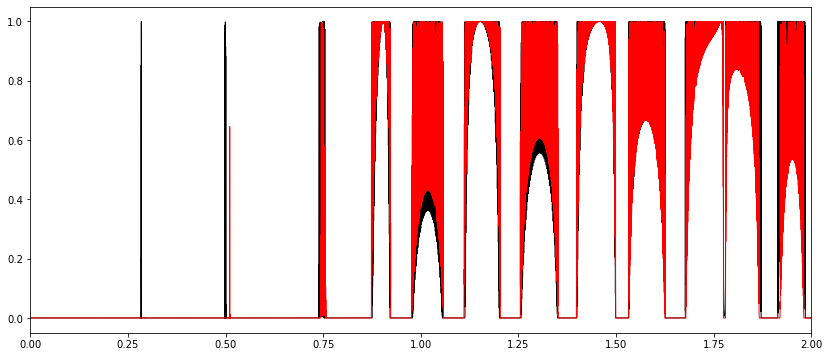

In [190]:
plt.figure(figsize=(14,6))
plt.plot(energy,cond,'-k',lw=1)
plt.plot(E_arr,np.array(T_uu),'-r',lw=1)
plt.xlim(0,2)

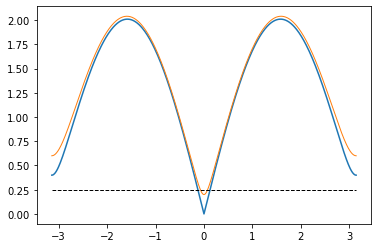

In [351]:
#plt.plot(momenta, -1j*np.sqrt(EE[:,20]**2-16*B**2+8*momenta**2+8*M*B+0j))
#Es=np.sqrt(np.array(energies)[:,2]**2-2*B**2*(1-np.cos(momenta))+0j)
#plt.plot(momenta,np.sqrt(abs(Es)**2))

n=2
Ly=1
ky=n*np.pi/Ly
kx=momenta

A=2
B=0.1
M=0.1*0


Etb1d=np.sqrt(A**2*(np.sin(kx)**2)+(M+2*B*(1-np.cos(kx)))**2+0j)
Etb2d=np.sqrt(A**2*(np.sin(kx)**2+np.sin(ky)**2)+(M+2*B*(2-np.cos(kx)-np.cos(ky)))**2+0j)
Etb2d_new=np.sqrt(A**2*(np.sin(kx)**2+np.sin(ky)**2)+(M+4*B*(np.sin(kx/2)**2+np.sin(ky/2)**2))**2+0j)

#plt.plot(momenta,Etb1d)
#plt.plot(momenta,Etb2d)
plt.plot(momenta,Etb2d_new)
plt.plot(momenta, np.array(energies)[:,1],'-',lw=1)
plt.plot(momenta, 0.25*np.ones(len(momenta)),'--k',lw=1)


In [168]:
evals, evecs = bands(0. , return_eigenvectors=True)

In [174]:
evals_l=[]
evecs_l = []
for k in momenta:
    evals, evecs = bands(k , return_eigenvectors=True)
    evals_l.append(evals)
    evecs_l.append(evecs)

(20, 20)

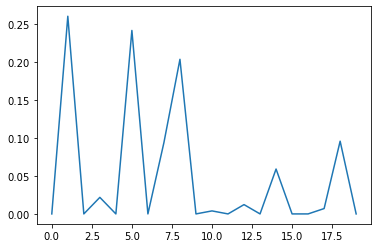

In [196]:
plt.plot(np.abs(evecs_l[0][9])**2)
np.shape(evecs)

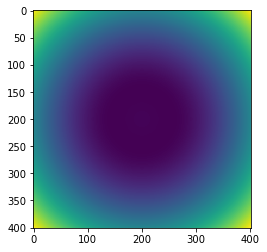

In [9]:
momenta = np.linspace(-np.pi, np.pi, 401)
A = 2
M = -0.50000001
B = 2
Δ = 1
Mp = M - Δ
Mm = M - Δ

kx=momenta
ky=momenta

KX,KY=np.meshgrid(kx,ky)

E=np.sqrt(A**2+(KX**2+KY**2)+(Mm+B*(KX**2+KY**2))**2)

plt.imshow(E)

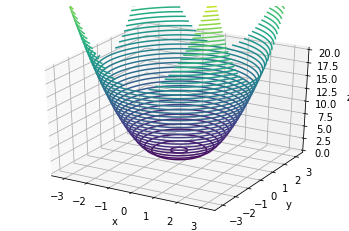

Wall time: 384 ms


In [13]:
%%time
from mpl_toolkits import mplot3d


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(KX, KY, E, 50, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_zlim(0,20)
plt.show()

In [17]:
class Person():
    def __init__(self, name):
        self.name = name
    
    def wrt_name(self):
        print(self.name)
        
    

In [18]:
p1=Person('Hasan')

In [19]:
p1.wrt_name()

Hasan
